In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 1. GPT-4 Vision API 이해하기
GPT-4 Vision API는 이미지 입력과 텍스트 프롬프트를 받아 이미지에 대한 상세한 설명이나 질문에 대한 답변을 생성해 줍니다. 이를 통해 이미지 캡셔닝, 장면 이해 등 다양한 작업에 활용할 수 있습니다.

In [26]:
!pip install openai av matplotlib pillow tqdm

import av
import openai
import base64
import io
import numpy as np
import matplotlib.pyplot as plt
import math
from PIL import Image
import time
import base64
import re
import json
from tqdm import tqdm

In [3]:
# OpenAI API 키 설정
OPENAI_KEY = # 실제 API 키로 대체하세요


In [4]:
from openai import OpenAI

client = OpenAI(api_key=OPENAI_KEY)

In [5]:
def read_video_pyav(container, frame_indices):
    frames = []  # 추출된 프레임을 저장할 리스트 초기화
    frame_counter = 0  # 현재 프레임 번호를 추적하기 위한 카운터 초기화
    frame_indices_set = set(frame_indices)  # 빠른 검색을 위해 프레임 인덱스 목록을 집합(set)으로 변환

    # 비디오 컨테이너로부터 프레임을 순차적으로 디코딩
    for frame in container.decode(video=0):
        # 현재 프레임 번호가 추출 대상 프레임 인덱스에 포함되어 있는지 확인
        if frame_counter in frame_indices_set:
            # 프레임을 RGB 포맷의 NumPy 배열로 변환
            img = frame.to_rgb().to_ndarray()
            # 변환된 이미지를 프레임 리스트에 추가
            frames.append(img)
            # 모든 대상 프레임을 추출했으면 루프 종료
            if len(frames) == len(frame_indices):
                break
        # 다음 프레임으로 이동하기 위해 카운터 증가
        frame_counter += 1

    # 추출된 프레임들을 NumPy 배열로 반환
    return np.array(frames)



```
system_instruction = """
Analyze the input online presentation video to evaluate the presenter’s non-verbal behaviors, and provide feedback based on the following five categories. For each category, identify any inappropriate behaviors exhibited by the presenter, describe the strengths and areas for improvement in a specific manner, and include concrete examples whenever possible. Additionally, ensure that feedback for each item is provided in 1-2 lines and include the corresponding problematic behavior keyword if an inappropriate behavior is detected.

**Categories and Problematic Behavior Keywords:**

1. **Eye Contact**
   - **Excessive gaze shifting**: When the presenter frequently looks away from the camera or shifts their gaze too often, it disrupts connection with the audience.
   - **Irregular gaze dispersion**: Inconsistent eye contact, where the presenter glances in different directions without a consistent focus, can reduce engagement.

2. **Facial Expressions**
   - **Expressionless**: A lack of expression throughout the presentation can make it challenging for the audience to stay engaged.
   - **Excessive facial changes**: Frequent, abrupt changes in facial expressions can be distracting and reduce the effectiveness of the message.

3. **Gestures and Hand Movements**
   - **Excessive hand movements**: Constant or overly exaggerated hand movements may distract the audience from the presentation content.
   - **Unnecessary hand movements**: Movements not relevant to the content may make the presentation appear less professional.

4. **Posture and Body Language**
   - **Slouched posture**: Poor posture, such as slouching, can project a lack of confidence.
   - **Excessive movement**: Frequent shifting or large body movements may distract the audience and affect the presentation flow.

5. **Sudden Actions and Movements**
   - **Unexpected actions**: Abrupt actions or gestures without purpose can divert the audience’s attention unexpectedly.
   - **Disrupting presentation flow**: Actions that break the flow of the presentation can make it harder for the audience to follow the message.

**Feedback Format:**

- **Eye Contact**
  - **Strengths:** [Specific positive feedback]
  - **Areas for Improvement:** [Specific improvement suggestions] [Problematic Behavior Keyword]

- **Facial Expressions**
  - **Strengths:** [Specific positive feedback]
  - **Areas for Improvement:** [Specific improvement suggestions] [Problematic Behavior Keyword]

- **Gestures and Hand Movements**
  - **Strengths:** [Specific positive feedback]
  - **Areas for Improvement:** [Specific improvement suggestions] [Problematic Behavior Keyword]

- **Posture and Body Language**
  - **Strengths:** [Specific positive feedback]
  - **Areas for Improvement:** [Specific improvement suggestions] [Problematic Behavior Keyword]

- **Sudden Actions and Movements**
  - **Strengths:** [Specific positive feedback]
  - **Areas for Improvement:** [Specific improvement suggestions] [Problematic Behavior Keyword]

**Additional Guidelines:**
- When pointing out inappropriate behaviors, provide specific examples along with suggestions for improvement.
- Include the corresponding problematic behavior keyword at the end of the "Areas for Improvement" section if an inappropriate behavior is detected.
- Balance feedback by highlighting both positive and inappropriate behaviors to maintain the presenter’s motivation.
- Explain how the presenter’s behaviors relate to the objectives of the presentation.
- Use concrete examples to enhance the clarity of the feedback.

**Examples:**

- **Eye Contact**
  - **Strengths:** "You maintained steady eye contact with the camera throughout the presentation, effectively engaging the audience."
  - **Areas for Improvement:** "You were frequently looking away from the camera during the presentation. Maintaining eye contact with the camera will facilitate better communication." [Excessive gaze shifting]

- **Facial Expressions**
  - **Strengths:** "You used appropriate facial expressions when explaining key points, which made your message clearer."
  - **Areas for Improvement:** "You appeared expressionless throughout the presentation, making it difficult to capture the audience’s interest. Try using varied facial expressions to convey emotions." [Excessive facial changes]
"""

```



In [6]:
system_instruction = """
입력된 온라인 발표 영상을 분석하여 발표자의 비언어적 행동을 평가하고, 다음 다섯 가지 카테고리를 기준으로 피드백을 제공해주세요. 각 카테고리마다 발표자가 보인 부적절한 행동을 식별하고, 개선이 필요한 점을 구체적으로 서술하며, 가능한 경우 구체적인 예시를 포함해주세요. 또한, 피드백은 각 항목당 1~2줄로 간결하게 제공되며, 부적절한 행동이 감지된 경우 해당 문제 행동의 정의 키워드를 포함시켜주세요.

**카테고리 및 부적절한 행동 키워드:**
1. **시선 처리 (Eye Contact)**
   - **과도한 시선 이동 (Excessive gaze shifting)**
     - **예시:** 발표자가 중요한 내용을 설명할 때마다 자주 화면 밖을 보거나 주변을 왔다 갔다 하며 시선을 지속적으로 이동합니다.
     - **감지 기준:**
       - 카메라를 바라보지 않고 다른 곳을 응시함.
   - **불규칙한 시선 분산 (Irregular gaze dispersion)**
     - **예시:** 발표 중간중간 시선을 갑자기 왼쪽, 오른쪽, 아래 등 다양한 방향으로 자주 돌려 일관된 시선 유지를 하지 못합니다.
     - **감지 기준:**
       - 발표 도중 시선을 특정 지점에 지속적으로 유지하지 못하고 불규칙하게 움직임.

2. **얼굴 표정 (Facial Expressions)**
   - **무표정 (Expressionless)**
     - **예시:** 발표 내내 무표정을 유지하며, 감정을 전달하지 못해 청중의 관심을 끌기 어렵습니다.
     - **감지 기준:**
       - 발표 시간의 80% 이상 동안 얼굴에 변화가 거의 없음.
       - 감정 표현이 부족하여 발표의 생동감이 떨어짐.
   - **과도한 표정 변화 (Excessive facial changes)**
     - **예시:** 발표 도중 지나치게 많은 표정 변화를 보여 자연스럽지 않고 산만하게 보입니다. 예를 들어, 중요한 포인트를 설명할 때 갑자기 크게 웃거나 찡그립니다.
     - **감지 기준:**
       - 표정이 자주 변하여 청중의 집중을 방해함.

3. **제스처 및 손동작 (Gestures and Hand Movements)**
   - **과도한 손동작 (Excessive hand movements)**
     - **예시:** 발표 내내 손을 지속적으로 흔들거나, 지나치게 많이 움직여 청중의 집중을 방해합니다. 예를 들어, 발표 내용과 무관하게 계속해서 손을 위아래로 움직입니다.
     - **감지 기준:**
       - 발표 내용과 관련 없는 손동작으로 청중의 주의를 분산시킴.
   - **불필요한 손동작 (Unnecessary hand movements)**
     - **예시:** 발표 내용과 관련 없는 손동작을 반복적으로 사용하여 산만하게 만듭니다. 예를 들어, 설명과 무관하게 손을 계속해서 얼굴 가까이로 가져갑니다.
     - **감지 기준:**
       - 손동작이 발표의 흐름과 무관하게 이루어져 청중의 집중을 방해함.

4. **자세 및 신체 언어 (Posture and Body Language)**
   - **구부정한 자세 (Slouched posture)**
     - **예시:** 발표자가 어깨를 움츠리고, 등을 구부정하게 하며, 비전문적인 인상을 줍니다.
     - **감지 기준:**
       - 갑자기 숙임, 화면을 벗어나는등 비전문적인 자세.
   - **과도한 움직임 (Excessive movement)**
     - **예시:** 발표 중 계속해서 자리에서 일어나거나, 몸을 크게 움직여 발표의 흐름을 방해합니다. 예를 들어, 중요한 내용을 설명할 때마다 자주 자리를 옮깁니다.
     - **감지 기준:**
       - 발표 중 5분 내에 3회 이상 자리 이동 또는 큰 움직임 발생.
       - 발표의 흐름을 방해하고 청중의 집중을 흐트러뜨림.

5. **갑작스러운 행동 및 움직임 (Sudden Actions and Movements)**
   - **예상치 못한 행동 (Unexpected actions)**
     - **예시:** 발표 도중 갑자기 손을 크게 올리거나, 몸을 급격하게 돌리는 등 예측할 수 없는 행동을 합니다. 예를 들어, 중요한 포인트 없이 갑자기 손을 크게 흔듭니다.
     - **감지 기준:**
       - 발표 중 예상치 못한 행동이 10분 발표 동안 2회 이상 발생.
       - 청중의 주의를 갑작스럽게 분산시켜 발표의 일관성을 해침.
   - **발표 흐름 방해 (Disrupting presentation flow)**
     - **예시:** 발표 중 중요한 내용을 설명할 때 갑자기 손을 올려 청중의 주의를 분산시킵니다. 예를 들어, 슬라이드를 설명하는 도중에 불필요하게 손을 크게 움직입니다.
     - **감지 기준:**
       - 발표 흐름을 방해하는 행동이 발표 도중 1회 이상 발생.
       - 발표의 일관성을 유지하지 못하고 청중의 집중을 분산시킴.

**피드백 형식:**

- **시선 처리 (Eye Contact)**
  - **개선이 필요한 점:** "발표 중간에 자주 화면 밖을 보시는 모습이 관찰되었습니다. 카메라를 향해 시선을 유지하시면 더 효과적인 소통이 가능할 것입니다." [과도한 시선 이동]
  - **권장 사항:** "카메라와 시선을 고정하여 청중과 일관된 연결을 유지하도록 연습해 보세요."

- **얼굴 표정 (Facial Expressions)**
  - **개선이 필요한 점:** "발표 내내 무표정하게 보이는 부분이 있어 청중의 관심을 끌기 어려웠습니다. 다양한 표정을 사용하여 감정을 표현해보세요." [무표정]
  - **권장 사항:** "강조할 때나 중요한 순간에 미소나 표정 변화를 추가하면 더 생동감 있는 발표가 될 것입니다."

- **제스처 및 손동작 (Gestures and Hand Movements)**
  - **개선이 필요한 점:** "발표 도중 손을 너무 많이 흔드셔서 산만하게 보일 수 있었습니다. 주요 포인트에서만 손동작을 사용해보시면 좋겠습니다." [과도한 손동작]
  - **권장 사항:** "핵심 포인트에만 손동작을 사용하여 발표의 주목도를 높여 보세요."

- **자세 및 신체 언어 (Posture and Body Language)**
  - **개선이 필요한 점:** "발표 중간에 자주 자세가 바뀌는 모습이 보였습니다. 안정된 자세를 유지하시면 더욱 집중된 발표가 될 것입니다." [구부정한 자세]
  - **권장 사항:** "앉거나 서 있을 때 몸을 일직선으로 유지해 안정감 있는 인상을 주도록 해보세요."

- **갑작스러운 행동 및 움직임 (Sudden Actions and Movements)**
  - **개선이 필요한 점:** "발표 도중 예상치 못한 손동작을 자주 사용하셨습니다. 손동작을 좀 더 계획적으로 사용하시면 좋을 것 같습니다." [예상치 못한 행동]
  - **권장 사항:** "강조가 필요할 때만 움직임을 추가하여 청중의 집중을 유도하세요."

**추가 지침:**

- 부적절한 행동을 지적할 때는 구체적인 예시와 함께 개선 방안을 제시해주세요.
- 긍정적인 행동은 제외하고, 개선이 필요한 행동에 집중하여 피드백을 제공해주세요.
- 가능한 한 구체적인 예시를 들어 피드백의 명확성을 높여주세요.
- 하나의 카테고리에서 여러 부적절한 행동이 감지될 경우, 모두를 언급하여 발표자가 명확하게 이해할 수 있도록 합니다.

"""


In [7]:
# 문제 행동의 정의 키워드 목록
PROBLEMATIC_BEHAVIORS = [
    "과도한 시선 이동",
    "불규칙한 시선 분산",
    "무표정",
    "과도한 표정 변화",
    "과도한 손동작",
    "불필요한 손동작",
    "구부정한 자세",
    "과도한 움직임",
    "예상치 못한 행동",
    "발표 흐름 방해"
]

In [8]:
# 사용자 프롬프트 생성 함수
def generate_user_prompt(img_type, img_b64_str):
    """
    주어진 이미지 데이터와 타입을 기반으로 비언어적 행동 평가를 요청하는 사용자 프롬프트를 생성합니다.
    """
    return f"Please evaluate the presenter's non-verbal behavior.\n\nImage data: data:{img_type};base64,{img_b64_str}"


In [9]:
# 이미지 인코딩 함수
def encode_image(image, max_size=(256, 256), quality=70):
    """
    이미지를 리사이즈하고 JPEG 형식으로 인코딩한 후 Base64 문자열로 반환합니다.

    Parameters:
    - image: PIL.Image 형식의 이미지
    - max_size: 이미지의 최대 크기 (기본값: 256x256)
    - quality: JPEG 압축 품질 (기본값: 70)

    Returns:
    - Base64로 인코딩된 이미지 문자열
    """
    # 이미지 리사이즈
    image.thumbnail(max_size)
    buffered = io.BytesIO()
    image.save(buffered, format="JPEG", quality=quality)
    img_b64_str = base64.b64encode(buffered.getvalue()).decode('utf-8')
    return img_b64_str


In [10]:
# 비디오 길이 가져오기 함수
def get_video_duration(video_path):
    """
    주어진 비디오 파일의 전체 길이(초 단위)를 반환합니다.

    Parameters:
    - video_path: 비디오 파일 경로

    Returns:
    - 비디오 길이 (초 단위)
    """
    try:
        container = av.open(video_path)
        stream = container.streams.video[0]
        duration = stream.duration * stream.time_base
        container.close()
        return duration
    except Exception as e:
        print(f"비디오 길이 가져오기 실패: {e}")
        return 0


In [11]:
# 비디오에서 프레임 추출 함수
def download_and_sample_video_local(video_path, start_time=0, duration=60, frame_interval=3):
    """
    주어진 비디오 파일에서 지정된 시작 시간과 지속 시간 내에서 일정 간격으로 프레임을 추출합니다.

    Parameters:
    - video_path: 비디오 파일 경로
    - start_time: 추출 시작 시간 (초 단위)
    - duration: 추출할 구간의 길이 (초 단위)
    - frame_interval: 프레임 추출 간격 (초 단위)

    Returns:
    - 추출된 프레임들의 리스트 (NumPy 배열 형식)
    """
    try:
        # 비디오 파일 열기
        container = av.open(video_path)
    except FileNotFoundError:
        print(f"비디오 파일을 찾을 수 없습니다: {video_path}")
        return None
    except av.AVError as e:
        print(f"비디오 파일을 여는 중 오류가 발생했습니다: {e}")
        return None

    stream = container.streams.video[0]
    fps = float(stream.average_rate) if stream.average_rate else 30.0

    # 세그먼트 내에서 추출할 프레임의 타임스탬프 계산
    num_frames = int(duration / frame_interval) + 1
    timestamps = [
        start_time + i * frame_interval
        for i in range(num_frames)
        if start_time + i * frame_interval <= start_time + duration
    ]

    frames = []
    index = 0
    seek_pts = int(start_time / stream.time_base)
    container.seek(seek_pts, any_frame=False, backward=True, stream=stream)

    for frame in container.decode(video=0):
        frame_time = frame.time
        if frame_time is None:
            continue
        if frame_time < start_time:
            continue
        if frame_time >= start_time + duration:
            break

        while index < len(timestamps) and frame_time >= timestamps[index]:
            frames.append(frame.to_rgb().to_ndarray())
            index += 1
            if index >= len(timestamps):
                break

    container.close()
    return np.array(frames)


In [32]:
def analyze_frames(frames, segment_idx, duration, segment_length, frame_interval=3):
    problematic_frames = []
    feedbacks = []

    PROBLEMATIC_BEHAVIORS = [
        "과도한 시선 이동",
        "불규칙한 시선 분산",
        "무표정",
        "과도한 표정 변화",
        "과도한 손동작",
        "불필요한 손동작",
        "구부정한 자세",
        "과도한 움직임",
        "예상치 못한 행동",
        "발표 흐름 방해"
    ]

    num_frames = len(frames)
    time_stamps = [
        segment_idx * segment_length + i * frame_interval
        for i in range(num_frames)
    ]

    for i, (frame, frame_time_sec) in enumerate(zip(frames, time_stamps)):
        minutes = int(frame_time_sec // 60)
        seconds = int(frame_time_sec % 60)
        timestamp = f"{minutes}m {seconds}s"

        # 사용자 프롬프트 생성
        user_prompt = (
            "다음 이미지에서 발표자의 비언어적 행동을 분석하고, system_instruction 내용에 기반해서 문제가 되는 행동이 있으면 피드백을 제공해주세요. "
            "문제가 없으면 '문제 없음'이라고 답해주세요."
        )

        img_type = "image/jpeg"

        # 이미지를 인코딩
        image = Image.fromarray(frame)
        img_b64_str = encode_image(image)

        # 사용자 메시지 구성
        user_message = f"{user_prompt}\n\n이미지 데이터: data:{img_type};base64,{img_b64_str}"

        try:
            response = client.chat.completions.create(
                model="gpt-4o-mini",  # 사용 가능한 모델 이름으로 설정
                messages=[
                    {
                        "role": "system",
                        "content": system_instruction
                    },
                    {
                        "role": "user",
                        "content": user_message
                    }
                ],
                max_tokens=600,
            )

            # 생성된 텍스트와 문제 행동 추출
            generated_text = response.choices[0].message.content
            behaviors_detected = re.findall(r'\[([^\[\]]+)\]', generated_text)

            # 공백 제거
            behaviors_detected = [behavior.strip() for behavior in behaviors_detected]

            # 디버깅을 위해 감지된 문제 행동 출력
            print(f"[디버그] 프레임 {i+1} 응답 텍스트: {generated_text}")
            print(f"[디버그] 감지된 문제 행동: {behaviors_detected}")
            print(f"[디버그] PROBLEMATIC_BEHAVIORS 리스트: {PROBLEMATIC_BEHAVIORS}")

            # 문제 행동 감지 여부 확인
            problem_detected = any(behavior in PROBLEMATIC_BEHAVIORS for behavior in behaviors_detected)

            if problem_detected:
                # 프레임과 세그먼트 정보를 저장
                problematic_frames.append((frame, segment_idx + 1, i + 1, timestamp))
                feedbacks.append(generated_text)

        except Exception as e:
            print(f"프레임 {i+1} 처리 중 오류 발생: {e}")

    return problematic_frames, feedbacks


In [34]:
def plot_problematic_frames(frames, feedbacks):
    if not frames:
        print("문제 있는 프레임이 없습니다.")
        return

    for i, (frame_info, feedback) in enumerate(zip(frames, feedbacks)):
        frame, segment_number, frame_number, timestamp = frame_info

        # 피드백을 콘솔에 출력
        print(f"Segment {segment_number}, Frame {frame_number} ({timestamp})")
        print("피드백:")
        print(feedback)
        print("-" * 50)

        # 이미지 표시
        plt.figure(figsize=(8, 6))
        plt.imshow(frame)
        plt.title(f"Segment {segment_number}, Frame {frame_number} ({timestamp})", fontsize=12)
        plt.axis('off')
        plt.tight_layout()
        plt.show()


In [35]:
def main():
    video_path = "/content/drive/MyDrive/kakaotech-14-ai/test_video2.mp4"  # 비디오 파일의 경로
    segment_length = 60  # 각 세그먼트의 길이 (초 단위)
    frame_interval = 3   # 프레임 추출 간격 (초 단위)

    # 비디오의 전체 길이(초 단위)를 가져옵니다.
    video_duration = get_video_duration(video_path)

    # 비디오를 세그먼트로 분할하기 위한 세그먼트 수 계산
    num_segments = math.ceil(video_duration / segment_length)
    print(f"비디오 전체 길이: {int(video_duration // 60)}분 {int(video_duration % 60)}초")
    print(f"총 {num_segments}개의 세그먼트로 분할됩니다.")

    all_segments_frames = []  # 모든 세그먼트의 프레임들을 저장할 리스트
    all_durations = []        # 각 세그먼트의 지속 시간을 저장할 리스트

    # 각 세그먼트별로 프레임을 추출합니다.
    for i in range(num_segments):
        start_time = i * segment_length  # 현재 세그먼트의 시작 시간 (초 단위)

        # 마지막 세그먼트의 지속 시간을 조정합니다.
        if i == num_segments - 1:
            duration = video_duration - start_time  # 남은 시간을 지속 시간으로 설정
        else:
            duration = segment_length  # 세그먼트 길이를 지속 시간으로 설정

        all_durations.append(duration)  # 세그먼트의 지속 시간을 저장

        print(f"샘플링 중인 세그먼트 {i+1}/{num_segments} (시작 시간: {int(start_time // 60)}분 {int(start_time % 60)}초)")

        # 해당 세그먼트에서 프레임을 추출합니다.
        clip = download_and_sample_video_local(
            video_path, start_time=start_time, duration=duration, frame_interval=frame_interval
        )

        # 추출된 프레임이 있으면 리스트에 추가합니다.
        if clip is not None and len(clip) > 0:
            all_segments_frames.append(clip)
        else:
            print(f"세그먼트 {i+1}에서 프레임을 추출할 수 없습니다.")

    print(f"총 {len(all_segments_frames)}개의 세그먼트가 추출되었습니다.")

    all_problematic_frames = []
    all_feedbacks = []

    # 모든 세그먼트에 대해 프레임 분석을 수행합니다.
    for idx, (segment_frames, duration) in enumerate(zip(all_segments_frames, all_durations)):
        print(f"\nAnalyzing segment {idx+1}/{len(all_segments_frames)}")
        # 각 세그먼트의 프레임들을 분석합니다.
        problematic_frames, feedbacks = analyze_frames(
            segment_frames, idx, duration, segment_length, frame_interval=frame_interval
        )
        all_problematic_frames.extend(problematic_frames)
        all_feedbacks.extend(feedbacks)

    # 문제 있는 프레임들을 시각화합니다.
    plot_problematic_frames(all_problematic_frames, all_feedbacks)


비디오 전체 길이: 2분 3초
총 3개의 세그먼트로 분할됩니다.
샘플링 중인 세그먼트 1/3 (시작 시간: 0분 0초)
샘플링 중인 세그먼트 2/3 (시작 시간: 1분 0초)
샘플링 중인 세그먼트 3/3 (시작 시간: 2분 0초)
총 3개의 세그먼트가 추출되었습니다.

Analyzing segment 1/3
[디버그] 프레임 1 응답 텍스트: 문제 없음.
[디버그] 감지된 문제 행동: []
[디버그] PROBLEMATIC_BEHAVIORS 리스트: ['과도한 시선 이동', '불규칙한 시선 분산', '무표정', '과도한 표정 변화', '과도한 손동작', '불필요한 손동작', '구부정한 자세', '과도한 움직임', '예상치 못한 행동', '발표 흐름 방해']
[디버그] 프레임 2 응답 텍스트: 문제 없음
[디버그] 감지된 문제 행동: []
[디버그] PROBLEMATIC_BEHAVIORS 리스트: ['과도한 시선 이동', '불규칙한 시선 분산', '무표정', '과도한 표정 변화', '과도한 손동작', '불필요한 손동작', '구부정한 자세', '과도한 움직임', '예상치 못한 행동', '발표 흐름 방해']
[디버그] 프레임 3 응답 텍스트: 문제 없음
[디버그] 감지된 문제 행동: []
[디버그] PROBLEMATIC_BEHAVIORS 리스트: ['과도한 시선 이동', '불규칙한 시선 분산', '무표정', '과도한 표정 변화', '과도한 손동작', '불필요한 손동작', '구부정한 자세', '과도한 움직임', '예상치 못한 행동', '발표 흐름 방해']
[디버그] 프레임 4 응답 텍스트: 문제 없음
[디버그] 감지된 문제 행동: []
[디버그] PROBLEMATIC_BEHAVIORS 리스트: ['과도한 시선 이동', '불규칙한 시선 분산', '무표정', '과도한 표정 변화', '과도한 손동작', '불필요한 손동작', '구부정한 자세', '과도한 움직임', '예상치 못한 행동', '발표 흐름 방해']
[디버그] 프레임 5 응답 텍스트: 문제 없음
[디버그] 감지된 문제

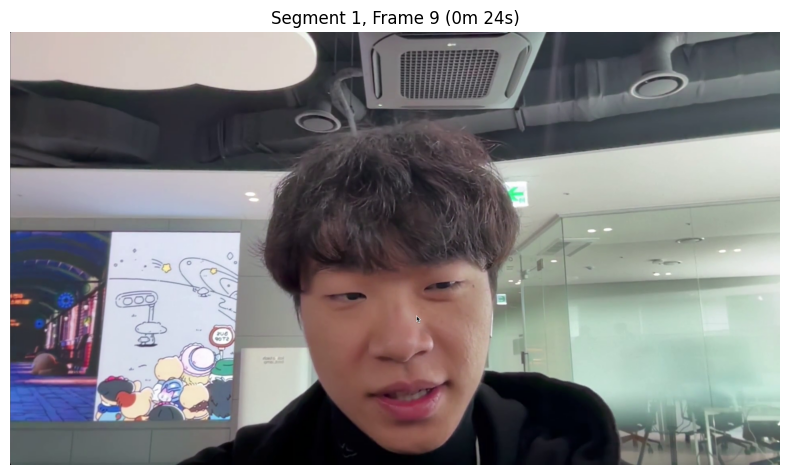

Segment 1, Frame 11 (0m 30s)
피드백:
- **시선 처리 (Eye Contact)**
  - **개선이 필요한 점:** "발표자가 시선을 특정 지점에 지속적으로 유지하지 못하고 불규칙하게 움직이는 모습이 관찰되었습니다. 카메라를 향해 시선을 일관되게 유지해 보시기 바랍니다." [불규칙한 시선 분산]
  
- **얼굴 표정 (Facial Expressions)**
  - **개선이 필요한 점:** "얼굴에 변화가 거의 없어서 감정 전달이 부족해 보입니다. 중요한 내용에서 표정을 변화시켜 청중의 관심을 끌어보세요." [무표정]
  
- **제스처 및 손동작 (Gestures and Hand Movements)**
  - **개선이 필요한 점:** "발표 도중 손 동작이 지나치게 많아 청중의 집중을 방해하는 경우가 있었습니다. 발표 내용과 관련된 동작에만 집중해 주세요." [과도한 손동작]
  
- **자세 및 신체 언어 (Posture and Body Language)**
  - **개선이 필요한 점:** "발표자가 구부정한 자세로 보이는데, 이는 비전문적인 인상을 줄 수 있습니다. 똑바로 서거나 앉는 것을 연습해 보세요." [구부정한 자세]
  
- **갑작스러운 행동 및 움직임 (Sudden Actions and Movements)**
  - **개선이 필요한 점:** "발표 중 예상치 못한 손동작이나 갑작스러운 움직임이 청중의 주의를 분산시켰습니다. 예측 가능한 동작으로 발표의 일관성을 유지하세요." [예상치 못한 행동]
--------------------------------------------------


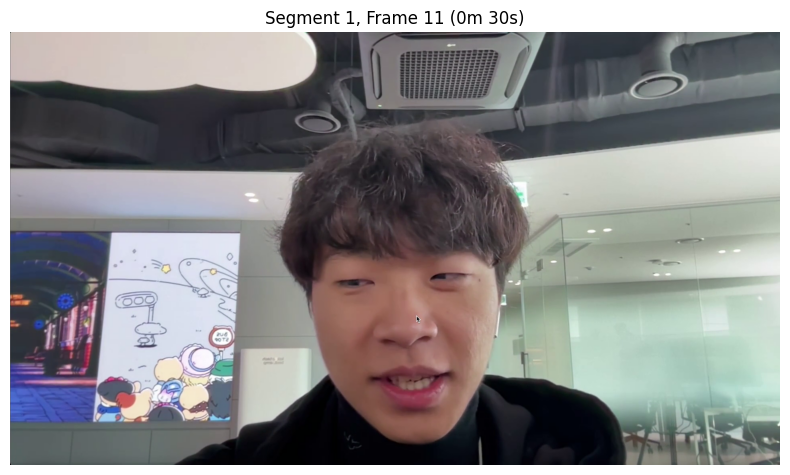

Segment 2, Frame 2 (1m 3s)
피드백:
- **시선 처리 (Eye Contact)**
  - **개선이 필요한 점:** "발표 중에 자주 화면 밖을 바라보시는 모습이 관찰되었습니다. 카메라를 향해 시선을 유지하시면 더 효과적인 소통이 가능할 것입니다." [과도한 시선 이동]

- **얼굴 표정 (Facial Expressions)**
  - **개선이 필요한 점:** "발표 내내 무표정을 유지하여 청중의 관심을 끌기 어려웠습니다. 다양한 표정을 사용하여 감정을 표현해보세요." [무표정]

- **제스처 및 손동작 (Gestures and Hand Movements)**
  - **개선이 필요한 점:** "발표 중 손을 지나치게 많이 흔들어 청중의 집중을 방해한 부분이 있었습니다. 주요 포인트에서만 손동작을 사용해보시면 좋겠습니다." [과도한 손동작]

- **자세 및 신체 언어 (Posture and Body Language)**
  - **개선이 필요한 점:** "어깨를 움츠리고 구부정한 자세로 비전문적인 인상을 주었습니다. 안정된 자세를 유지하시면 더욱 집중된 발표가 될 것입니다." [구부정한 자세]

- **갑작스러운 행동 및 움직임 (Sudden Actions and Movements)**
  - **개선이 필요한 점:** "발표 도중 예상치 못한 행동을 몇 번 보이셨습니다. 손동작을 좀 더 계획적으로 사용하시면 좋을 것 같습니다." [예상치 못한 행동]
--------------------------------------------------


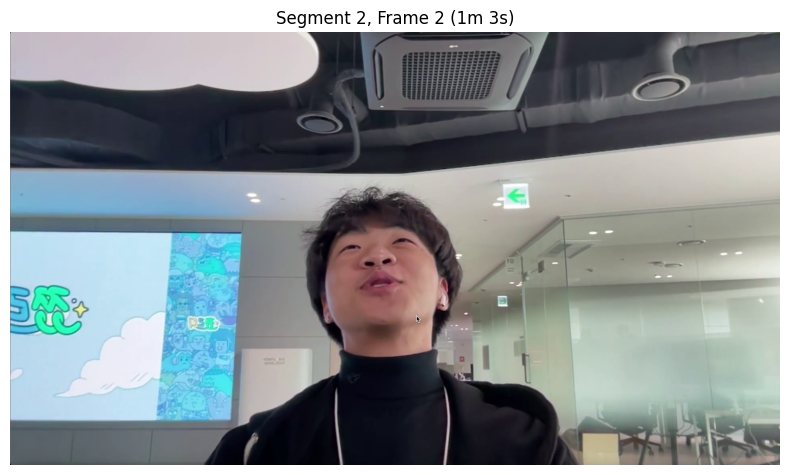

Segment 2, Frame 8 (1m 21s)
피드백:
- **시선 처리 (Eye Contact)**
  - **개선이 필요한 점:** "발표 중간에 화면 밖을 보시는 모습이 관찰되었습니다. 카메라를 향해 시선을 유지하시면 더 효과적인 소통이 가능할 것입니다." [과도한 시선 이동]
  - **권장 사항:** "카메라와 시선을 고정하여 청중과 일관된 연결을 유지하도록 연습해 보세요."

- **얼굴 표정 (Facial Expressions)**
  - **개선이 필요한 점:** "발표 내내 무표정하게 보이는 부분이 있어 청중의 관심을 끌기 어려웠습니다. 다양한 표정을 사용하여 감정을 표현해보세요." [무표정]
  - **권장 사항:** "강조할 때나 중요한 순간에 미소나 표정 변화를 추가하면 더 생동감 있는 발표가 될 것입니다."

- **제스처 및 손동작 (Gestures and Hand Movements)**
  - **문제 없음**

- **자세 및 신체 언어 (Posture and Body Language)**
  - **개선이 필요한 점:** "발표 중 지속적으로 구부정한 자세를 유지하시는 모습이 보였습니다. 이를 개선하여 더 전문적인 인상을 주시면 좋겠습니다." [구부정한 자세]
  - **권장 사항:** "앉거나 서 있을 때 몸을 일직선으로 유지해 안정감 있는 인상을 주도록 해보세요."

- **갑작스러운 행동 및 움직임 (Sudden Actions and Movements)**
  - **문제 없음**
--------------------------------------------------


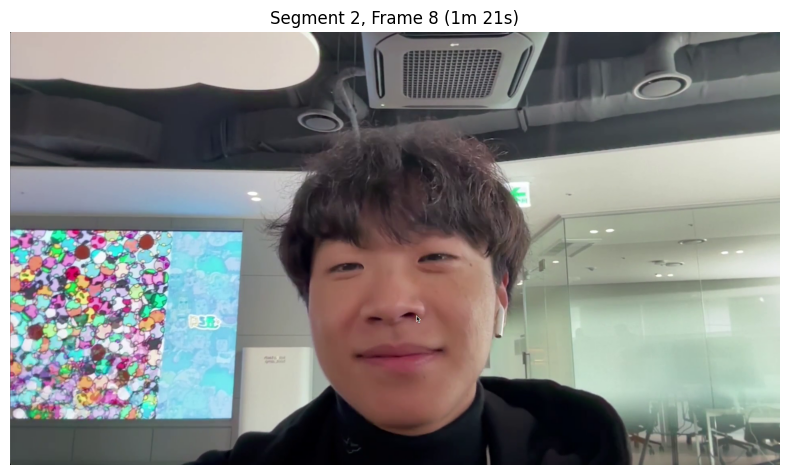

Segment 2, Frame 12 (1m 33s)
피드백:
- **시선 처리 (Eye Contact)**
  - **개선이 필요한 점:** "발표자가 카메라를 바라보지 않고 주변을 자주 응시하는 모습이 있습니다. 카메라와 눈을 맞추는 연습을 하셔서 청중과의 연결을 강화해보세요." [과도한 시선 이동]

- **얼굴 표정 (Facial Expressions)**
  - **개선이 필요한 점:** "발표 전반에 걸쳐 무표정한 모습이 확인되었습니다. 감정을 표현하는 표정을 추가하여 발표의 생동감을 높여보세요." [무표정]

- **제스처 및 손동작 (Gestures and Hand Movements)**
  - **개선이 필요한 점:** "발표 중 손동작이 과도하게 많이 보여 주의를 분산시킬 수 있었습니다. 중요한 순간에만 손동작을 사용해보세요." [과도한 손동작]

- **자세 및 신체 언어 (Posture and Body Language)**
  - **개선이 필요한 점:** "발표자께서 구부정한 자세로 서 있는 모습이 관찰되었습니다. 보다 바로 서 있는 자세를 유지하여 전문적인 인상을 주세요." [구부정한 자세]

- **갑작스러운 행동 및 움직임 (Sudden Actions and Movements)**
  - **개선이 필요한 점:** "예상치 못한 손동작이 발견되었습니다. 이러한 갑작스러운 행동은 발표의 흐름을 방해할 수 있으니 더 계획적으로 움직이는 것이 좋습니다." [예상치 못한 행동]
--------------------------------------------------


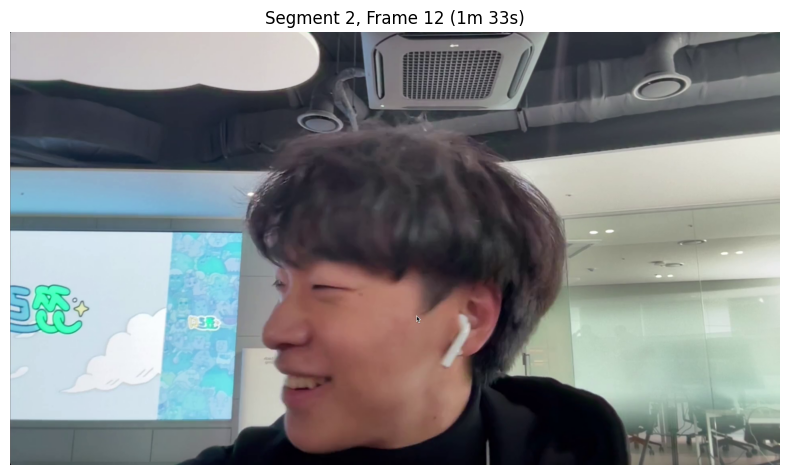

Segment 3, Frame 1 (2m 0s)
피드백:
- **시선 처리 (Eye Contact)**
  - **개선이 필요한 점:** "발표자의 시선이 자주 주변으로 이동하여 청중과의 연결이 약해 보입니다. 카메라를 바라보는 것을 연습하시면 좋겠습니다." [과도한 시선 이동]
  
- **얼굴 표정 (Facial Expressions)**
  - **문제 없음**

- **제스처 및 손동작 (Gestures and Hand Movements)**
  - **개선이 필요한 점:** "손동작이 발표 내용과 무관하게 자주 이루어지는 모습이 관찰되었습니다. 주요 포인트에 집중하여 손동작을 제한해 보세요." [불필요한 손동작]

- **자세 및 신체 언어 (Posture and Body Language)**
  - **개선이 필요한 점:** "구부정한 자세가 감지되어 비전문적인 인상을 주었습니다. 앉거나 설 때 더 똑바른 자세를 유지하도록 해보세요." [구부정한 자세]

- **갑작스러운 행동 및 움직임 (Sudden Actions and Movements)**
  - **문제 없음**
--------------------------------------------------


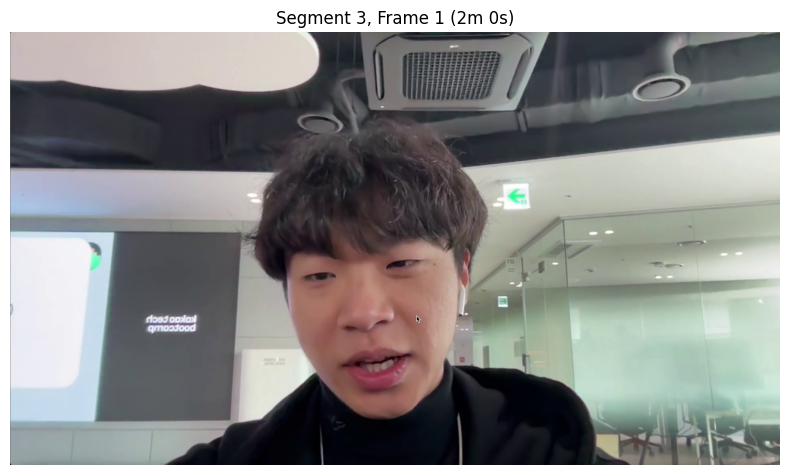

In [36]:
if __name__ == "__main__":
    main()

ver1. 해결문제
- 정확도 이슈 (일단 정확하게 올려야 할지도 -> 파인튜닝 필요..?)
- 프레임 간격 더 줄이기 (3초 -> 1초)
- webm 형태로 제공? 이건 추후 의논 필요.